# Hierarchical matrices

This notebook is an introduction to hierarchical matrices, following the examples from Rjasanow and Steinbach's "The fast solution of boundary integral equations".

## Low rank approximation of a matrix

Say we have the the 2D square $[0,1]\times[0,1]$, discretized in $N\times N$ nodes, and form a matrix with kernel

\begin{equation}
K(x,y) = \frac{1}{\alpha + x + y}
\end{equation}

where $\alpha$ avoids the singularity.

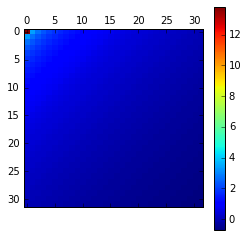

In [207]:
import numpy
from matplotlib import pyplot
%matplotlib inline

def generate_K(xmin, xmax, ymin, ymax, N, alpha, kernel):
    x = numpy.linspace(xmin, xmax, N)
    y = numpy.linspace(ymin, ymax, N)

    X, Y = numpy.meshgrid(x,y)

    K = kernel(X,Y,alpha) 

    return K

def kernel_1(X,Y,alpha):
    return 1/(alpha+X+Y)

xmin = 0.
xmax = 1.
ymin = 0.
ymax = 1.

alpha = 1e-6

N = 32

K_32 = generate_K(xmin, xmax, ymin, ymax, N, alpha, kernel_1)

pyplot.matshow(numpy.log(K_32))
pyplot.colorbar()

As we could suspect, the matrix `K` has a peak in the $(0,0)$ corner which would be singular if $\alpha=0$.

Remember the singular value decomposition? It decomposes a matrix $A$ into 

\begin{equation}
A = U\Sigma V^T
\end{equation}

where $U$ and $V$ are matrices whose columns are the right and left singular vectors, respectively, and $\Sigma$ is a diagonal matrix with the singular values. See the [Wikipedia](https://en.wikipedia.org/wiki/Singular_value_decomposition) entry for more details.

Let's study the singular values of matrix `K`, using the [`numpy.linalg.svd`](https://docs.scipy.org/doc/numpy/reference/generated/numpy.linalg.svd.html) function

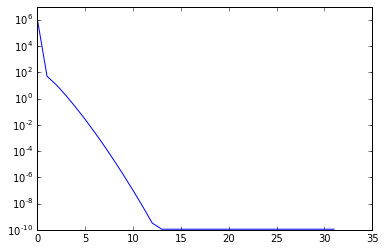

In [208]:
U_32,s_32,V_32 = numpy.linalg.svd(K_32)
pyplot.semilogy(s_32)

We can see that the singular values quickly drop to near 0. This means that the $32\times 32$ `K` matrix does not really need the full $32$-long rank to be well represented, but perhaps using only $13$ singular values it can be well represented.  

What happens with higher $N$? Let's try $N=1024$

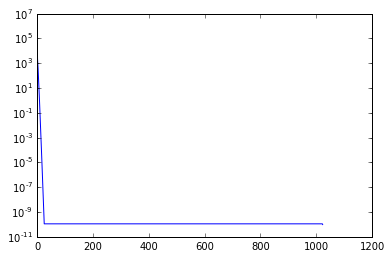

In [209]:
N = 1024

K_1024 = generate_K(xmin, xmax, ymin, ymax, N, alpha, kernel_1)
U_1024,s_1024,V_1024 = numpy.linalg.svd(K_1024)
pyplot.semilogy(s_1024)

The effect is even worse! We (relatively) need even less singular values to have a good approximation of $K$. 

Using this idea, we can write a *low rank* approximation of `K` by using only the $r$ biggest singular values. Let's use the first 13 singular values to reconstruct a low rank approximation of `K_32`: 

In [210]:
def Frobenius_rel_norm(A, A_approx):
    difference = numpy.sqrt(numpy.sum((A-A_approx)**2))
    relative = numpy.sqrt(numpy.sum((A)**2))
    
    return difference/relative
    
def low_rank_approx(A, cutoff):
    
    N = len(A)
    
    U,s,V = numpy.linalg.svd(A)
    
    Sigma_approx = numpy.zeros((N,N))
    Sigma_approx[numpy.arange(cutoff),numpy.arange(cutoff)] = s[:cutoff]

    A_approx = numpy.dot(numpy.dot(U, Sigma_approx), V) # V is already transposed
    
    return A_approx

cutoff = 13
K_approx = low_rank_approx(K_32, cutoff)
error = Frobenius_rel_norm(K_32, K_approx)
print error

3.56973264772e-16


That is a very good approximation! Up to machine precision! This means that the actual rank of the matrix is not equal to the number of columns, but actually much less.

One question is: how big of a rank do we need for a given error? Let's code that up.

In [211]:
def low_rank_approx_error(A, epsilon):
    
    N = len(A)
    
    U,s,V = numpy.linalg.svd(A)
    
    Sigma_approx = numpy.zeros((N,N))
    
    error = 1.
    rank = 1
    
    while error>epsilon:
    
        Sigma_approx[numpy.arange(rank),numpy.arange(rank)] = s[:rank]
        A_approx = numpy.dot(numpy.dot(U, Sigma_approx), V) # V is already transposed
        error = Frobenius_rel_norm(A, A_approx)
        
        rank += 1
        
    return A_approx, rank

Let's aim at $\epsilon = 10^{-6}$

In [212]:
epsilon = 1e-6
K_approx, rank = low_rank_approx_error(K_32, epsilon)
print rank

5


Only 4! 

Unfortunately, a SVD takes $O(N^3)$ operations, which defeats the point of having a *fast* method, but we'll illustrate the main ideas with it, and discuss a more efficient way to obtain low-rank approximations later.

## Hierarchical block decomposition of a matrix

Perhaps the example from before was way too easy. Let's try out a different kernel:

\begin{equation}
K(x,y) = \frac{1}{(x-y)^2+\alpha}
\end{equation}

which should give a diagonally dominant matrix

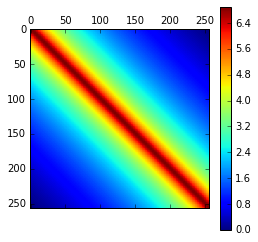

In [213]:
def kernel_2(X,Y,alpha):
    return 1/(alpha+(X-Y)**2)

N = 256
alpha = 1e-3
K = generate_K(xmin, xmax, ymin, ymax, N, alpha, kernel_2)

pyplot.matshow(numpy.log(K))
pyplot.colorbar()

Let's look at the singular values

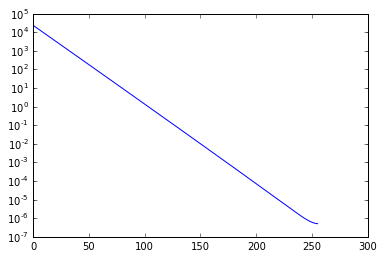

In [214]:
U,s,V = numpy.linalg.svd(K)
pyplot.semilogy(s)

These decay a lot slower than the previous case! 

If we wanted an approximation which is accurate up to $\epsilon=10^{-6}$, what would be the required rank?

In [215]:
K_approx, rank = low_rank_approx_error(K, epsilon)
print rank

143


Much more than the $5$ we saw in the previous case!

From inspecting the matrix, we can see that most of the information is concentrated on the diagonal. If we subdivide the matrix into four sub-matrices as

\begin{equation}
K = \left(
\begin{array}{c c}
K_{11} & K_{12}\\
K_{21} & K_{22}
\end{array}
\right)
\end{equation}

The most important information would be concentrated on the $K_{11}$ and $K_{22}$ blocks. Let's look at the singular values of each block individually

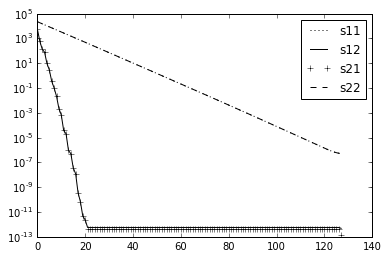

In [216]:
N = len(K)
K11 = K[:N/2,:N/2]
K12 = K[:N/2,N/2:]
K21 = K[N/2:,:N/2]
K22 = K[N/2:,N/2:]

U11,s11,V11 = numpy.linalg.svd(K11)
U12,s12,V12 = numpy.linalg.svd(K12)
U21,s21,V21 = numpy.linalg.svd(K21)
U22,s22,V22 = numpy.linalg.svd(K22)

pyplot.semilogy(s11, ls=':', label='s11', c='k')
pyplot.semilogy(s12, ls='-', label='s12', c='k')
pyplot.semilogy(s21, ls='', marker='+', label='s21', c='k')
pyplot.semilogy(s22, ls='--', label='s22', c='k')
pyplot.legend()

That is interesting! The singular values of the off-diagonal blocks decay pretty rapidly, whereas the diagonal blocks have a similar behavior compared to the original matrix (we kind of expected this, right?).

This would mean that the off-diagonal block matrices have low-rank approximations which have a *very* low rank. Let's test that for $\epsilon=10^{-6}$

In [217]:
K11_approx, rank11 = low_rank_approx_error(K11, epsilon)
K12_approx, rank12 = low_rank_approx_error(K12, epsilon)
K21_approx, rank21 = low_rank_approx_error(K21, epsilon)
K22_approx, rank22 = low_rank_approx_error(K22, epsilon)

print rank11, rank12, rank21, rank22

73 10 10 73


I'm good with only rank 10 for the off diagonal submatrices. Let's subdivide the diagonal matrices further and look at their rank

In [218]:
N = len(K11)
K11_11 = K11[:N/2,:N/2]
K11_12 = K11[:N/2,N/2:]
K11_21 = K11[N/2:,:N/2]
K11_22 = K11[N/2:,N/2:]

K22_11 = K22[:N/2,:N/2]
K22_12 = K22[:N/2,N/2:]
K22_21 = K22[N/2:,:N/2]
K22_22 = K22[N/2:,N/2:]

K11_11_approx, rank11_11 = low_rank_approx_error(K11_11, epsilon)
K11_12_approx, rank11_12 = low_rank_approx_error(K11_12, epsilon)
K11_21_approx, rank11_21 = low_rank_approx_error(K11_21, epsilon)
K11_22_approx, rank11_22 = low_rank_approx_error(K11_22, epsilon)

K22_11_approx, rank22_11 = low_rank_approx_error(K22_11, epsilon)
K22_12_approx, rank22_12 = low_rank_approx_error(K22_12, epsilon)
K22_21_approx, rank22_21 = low_rank_approx_error(K22_21, epsilon)
K22_22_approx, rank22_22 = low_rank_approx_error(K22_22, epsilon)

print 'Submatrix 11'
print rank11_11, rank11_12, rank11_21, rank11_22

print 'Submatrix 22'
print rank22_11, rank22_12, rank22_21, rank22_22

Submatrix 11
38 9 9 38
Submatrix 22
38 9 9 38


Nice! The rank of the off diagonals keeps dropping! Moreover, in terms of memory, it is better to have four small matrices of rank 38 than one large matrix of rank 143!

We could continue subdividing, generating a hierarchical structure of the matrix which will use a lot less memory than the original matrix.

This worked very well because our points are nicely ordered such that the value is monotonically decaying as we move away from the diagonal. However, this might not be the case in, for example, boundary element methods (BEM). In BEM the matrix is diagonally dominant, but there is no guarantee that the values decrease monotonically: two elements that are far in the ordering, might be close-by in space. Then, to construct admissible blocks, we need to perform some permutations of rows and columns. In BEM, this is dealt with by the Adaptive-Cross Approximation (ACA) algorithm.